# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

### Homework 1 is due 2/13

In [2]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"


import statsmodels.formula.api as sm
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
r_utils = importr('utils')
# if there are errors about missing R packages, uncomment and run the lines below:
#r_utils.install_packages('codetools')
#r_utils.install_packages('gam')
r_splines = importr('splines')
r_smooth_spline = robjects.r['smooth.spline'] #extract R function
r_gam_lib = importr('gam')
base = importr('base')
r_gam = r_gam_lib.gam #extract R function
r_glm = robjects.r['glm'] #extract R function
r_anova = robjects.r['anova'] #extract R function


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for Airbnb units in the Boston area from 2017 to 2018. Note that some of the rows in the `.csv` file refer to dates in the future. These refer to bookings that have been made far in advance.

Start by loading the data using pandas:

In [4]:
df_train = pd.read_csv("calendar_train.csv")
df_test = pd.read_csv("calendar_test.csv")

In [5]:
display(df_train.head())
display(df_train.dtypes)

,listing_id,date,available,price
0,20872145,9/21/18,f,NaN
1,20872145,9/19/18,f,NaN
2,20872145,9/18/18,f,NaN
3,20872145,9/17/18,f,NaN
4,20872145,9/16/18,f,NaN


listing_id      int64
date           object
available      object
price         float64
dtype: object

We could see there are some days with no price value. Thus we will drop the missing values first before further analysis.

In [6]:
df_train = df_train.dropna()
df_test = df_test.dropna()

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

*Hint*: You will want to first convert the `date` column into Python dates using `datetime.datetime.strptime(arg1,arg2).date()` and providing the appropriate arguments.

In [7]:
df_train.head()

,listing_id,date,available,price
123,20872145,4/2/18,t,62.0
124,20872145,4/1/18,t,59.0
125,20872145,3/31/18,t,75.0
126,20872145,3/30/18,t,71.0
127,20872145,3/28/18,t,51.0


In [8]:
df_train['date'] = df_train['date'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%y").date())
df_test['date'] = df_test['date'].apply(lambda x: datetime.datetime.strptime(x, "%m/%d/%y").date())

In [9]:
df_train['weekday'] = df_train['date'].apply(lambda x: x.weekday())
df_train['month'] = df_train['date'].apply(lambda x: x.month)
df_test['weekday'] = df_test['date'].apply(lambda x: x.weekday())
df_test['month'] = df_test['date'].apply(lambda x: x.month)

**In this homework, we use average price as the response variable.**

In [10]:
train_price_m = df_train.groupby(['month'])['price'].mean()
train_price_w = df_train.groupby(['weekday'])['price'].mean()

Text(0.5, 1.0, 'Average Price by Day of the Week')

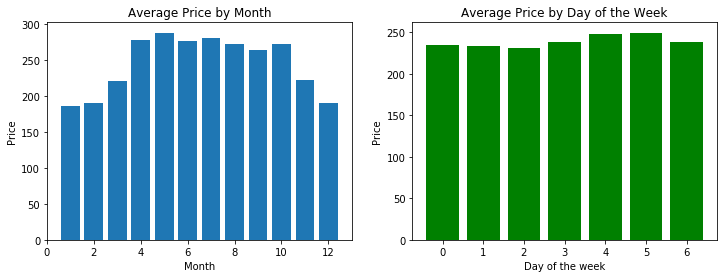

In [11]:
plt.figure(figsize = [12,4])
plt.subplot(1,2,1)
# equivalent but more general
plt.bar(train_price_m.index, train_price_m)
plt.xlabel("Month")
plt.ylabel("Price")
plt.title("Average Price by Month")

plt.subplot(1,2,2)
# equivalent but more general
plt.bar(train_price_w.index, train_price_w, color='g')
plt.xlabel("Day of the week")
plt.ylabel("Price")
plt.title("Average Price by Day of the Week")

**Based on the plot of average price by month, we could see that the price has strong seasonality that prices between April and October is higher than the rest of months. This makes sense because April to October is tourism season, the demand for Airbnb rental is higher, thus the price is higher.    
Based on the plot of average price by day of the week, the price of weekends (Friday and Saturday) is higher than that of weekdays. This also makes sense that people tend to travel during weekends rather than weekdays. Thus, the demand for housing is higher as well as the price is higher. **

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the average price of an Airbnb rental on that date. For this part of the question, you can ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Regression models with different basis functions:
    * Simple polynomials with degrees 5, 25, and 50
    * Cubic B-splines with the knots chosen by visual inspection of the data
    * Natural cubic splines with the degree of freedom chosen by cross-validation on the training set.
    
2. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

In each case, analyze the effect of the relevant tuning parameters on the training and test $R^2$ and give explanations for what you observe.

Is there a reason you would prefer one of these methods over the other (hint: you may want to consider $R^2$)?

*Hint*: The functions `bs` (for B-spline basis functions) and `ns` (for natural cubic spline basis functions) are available  in the `r_splines` library.


In [12]:
min_train = df_train['date'].min()
min_test = df_test['date'].min()
df_train['date_num'] = df_train['date'].apply(lambda x: (x - min_train).days)
df_test['date_num'] = df_test['date'].apply(lambda x: (x - min_test).days)

In [13]:
new_train = pd.DataFrame({'price' : (df_train.groupby('date_num')['price'].mean()).values,
                         'date': (df_train.groupby('date_num')['price'].mean()).index})
new_test = pd.DataFrame({'price' : (df_test.groupby('date_num')['price'].mean()).values,
                         'date': (df_test.groupby('date_num')['price'].mean()).index})

In [14]:
new_train.head()

,price,date
0,370.173410,0
1,409.298701,1
2,299.128713,2
3,282.768908,3
4,275.933202,4


In [15]:
r_lm = robjects.r["lm"]
r_predict = robjects.r["predict"]

In [16]:
def make_r_df(df):
    r_df = pd.DataFrame(columns = list(df))
    r_df = robjects.DataFrame({'price': robjects.FloatVector(df['price']),
                               'date': robjects.FloatVector(df['date'])})
    return r_df

In [17]:
# Convert python df to robjects
train_r = make_r_df(new_train)
test_r = make_r_df(new_test)

**Simple polynomial models with degree 5, 25, 50**

In [18]:
#Simple polynomial models with degree 5, 25, 50
ploy5_formula = robjects.Formula("price~poly(date,5)")
lm_poly5 = r_lm(formula=ploy5_formula, data=train_r)

ploy25_formula = robjects.Formula("price~poly(date,25)")
lm_poly25 = r_lm(formula=ploy25_formula, data=train_r)

ploy50_formula = robjects.Formula("price~poly(date,50, raw=T)")
lm_poly50 = r_lm(formula=ploy50_formula, data=train_r)

In [19]:
#make predictions with polynomial models
predictions_poly5 = r_predict(lm_poly5, test_r)
predictions_poly25 = r_predict(lm_poly25, test_r)
predictions_poly50 = r_predict(lm_poly50, test_r)

In [20]:
r2_poly5_train = base.summary(lm_poly5).rx2('r.squared')
r2_poly5_test = r2_score(new_test['price'], predictions_poly5)

r2_poly25_train = base.summary(lm_poly25).rx2('r.squared')
r2_poly25_test = r2_score(new_test['price'], predictions_poly25)

r2_poly50_train = base.summary(lm_poly50).rx2('r.squared')
r2_poly50_test = r2_score(new_test['price'], predictions_poly50)

In [21]:
R2_poly_df = pd.DataFrame({'degree':[5,25,50],
                          'train_r2': [r2_poly5_train,r2_poly25_train,r2_poly50_train],
                          'test_r2': [r2_poly5_test,r2_poly25_test,r2_poly50_test]})

R2_poly_df

,degree,train_r2,test_r2
0,5,[0.7168986374319599],0.685017
1,25,[0.7930590005573271],0.746201
2,50,[0.786235192227862],0.740341


**Based on the above table, we could see that polynomial with degree 25 has the highest R2 (0.746201) for test set.**

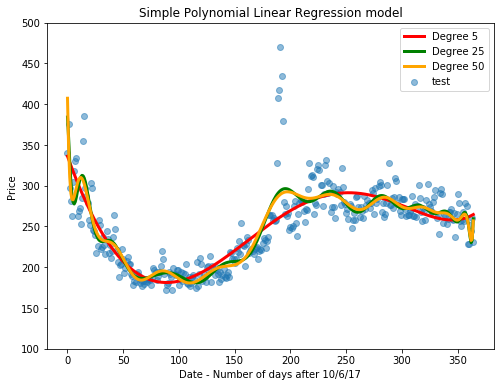

In [22]:
plt.figure(figsize = (8,6))
plt.ylim(100,500)
plt.scatter(new_test['date'], new_test['price'],alpha=0.5, label = 'test')
plt.plot(new_test['date'],predictions_poly5, c='r', 
         linewidth=3, label = 'Degree 5')
plt.plot(new_test['date'],predictions_poly25, c='g', 
         linewidth=3, label = 'Degree 25')
plt.plot(new_test['date'],predictions_poly50, c='orange', 
         linewidth=3, label = 'Degree 50')
plt.title('Simple Polynomial Linear Regression model')

plt.xlabel("Date - Number of days after 10/6/17")
plt.ylabel("Price")
plt.legend()

**When degree is 25 we would get the best performance on the test data. At first, $R^2$ of the training set and the test set will increase as polynomial degree increases. However,after some point, as the degree increases, the $R^2$ of the training set will increase while that of the test set will decrease. This could be due to:**

**The higher order the polynomial degree is, it will better capture the changes in the training data. However, as the degree continues to increase, it might lead to overfitting. In this case, the $R^2$ on the test set will decrease.**

**Cubic B-splines**

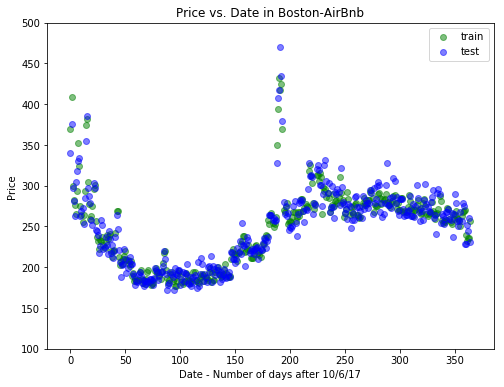

In [24]:
plt.figure(figsize = (8,6))
plt.ylim(100,500)
plt.scatter(new_train['date'], new_train['price'], c = 'g', alpha=0.5, label = 'train')
plt.scatter(new_test['date'], new_test['price'], c = 'blue', alpha=0.5, label = 'test')
plt.title('Price vs. Date in Boston-AirBnb')
plt.xlabel("Date - Number of days after 10/6/17")
plt.ylabel("Price")
plt.legend()

In [35]:
# Fit Cubic B-splines
# Chose knots 90, 225, 255, 280 by visual inspection
r_quarts = robjects.FloatVector(np.array([90,225,255,280])) 
r_date = robjects.FloatVector(new_train['date'])
bs_design = r_splines.bs(r_date, knots=r_quarts)

bs_formula = robjects.Formula("price ~ bs(date, knots=r_quarts)")
bs_formula.environment['r_quarts'] = r_quarts
         
lm_bs = r_lm(bs_formula, data=train_r)

In [36]:
predictions_bs = r_predict(lm_bs, test_r)

r2_bs_train = base.summary(lm_bs).rx2('r.squared')
r2_bs_test = r2_score(new_test['price'], predictions_bs)
print("R2 for Cubic B-splines on train:{}".format(r2_bs_train))
print("R2 for Cubic B-splines on test:{} ".format(r2_bs_test))

R2 for Cubic B-splines on train:[1] 0.7348314

R2 for Cubic B-splines on test:0.7032038818159889 


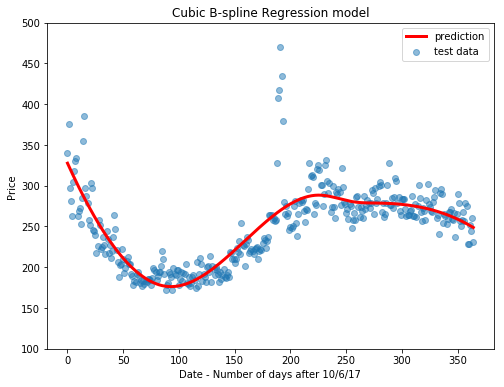

In [39]:
plt.figure(figsize = (8,6))
plt.ylim(100,500)
plt.scatter(new_test['date'], new_test['price'],alpha=0.5,label = 'test data')
plt.plot(new_test['date'],predictions_bs, c='r', linewidth=3, label = 'prediction')
plt.title('Cubic B-spline Regression model')
plt.xlabel("Date - Number of days after 10/6/17")
plt.ylabel("Price")
plt.legend()

**By visual inspection, we could see there are some changes in the trend of the training and test data set when the date is 90, 225, 255, 280. Thus, we would like to choose 4 knots and build a cubic B-spline model. The $R^2$ on the test data is 0.7032, smaller than polynomial with degree 25. The cubic b-spline captures the curvature at each knots. The performance of cubic b-spline on training set increases as the increase in knots while it might also lead to overfitting if the number of knots is very big. **

**Natural cubic splines with the degree of freedom chosen by cross-validation on the training set**

In [40]:
new = pd.concat([new_train, new_test])

In [56]:
Score=[]
foldscore=[]
kf = KFold(n_splits=5, shuffle = True)
df=range(4,250)
#sample = df_train.sample(frac=0.1, replace=True)
for i in df: 
    for train_index, test_index in kf.split(new_train):
        train, test = new_train.iloc[train_index], new_train.iloc[test_index]
        train_df = make_r_df(train)
        test_df = make_r_df(test)
        formula = "price ~ ns(date, df={})".format(i)
        ns_formula = robjects.Formula(formula)
        ns_model = r_lm(ns_formula, data=train_df)
        predictions = r_predict(ns_model, test_df)
        score = r2_score(test['price'], predictions)
        Score.append(score)
    foldscore.append(np.mean(Score))

Text(0, 0.5, 'R2')

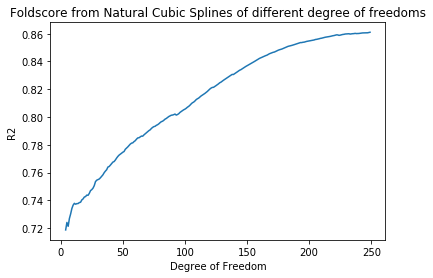

In [57]:
plt.plot(df, foldscore)
plt.title('Foldscore from Natural Cubic Splines of different degree of freedoms')
plt.xlabel("Degree of Freedom")
plt.ylabel("R2")

In [61]:
max_df = foldscore.index(max(foldscore))

In [62]:
ns_formula = robjects.Formula("price ~ ns(date, df={})".format(max_df))
ns_model = r_lm(ns_formula, data=train_r)

In [63]:
predictions_ns = r_predict(ns_model, test_r)

r2_ns_train = base.summary(ns_model).rx2('r.squared')
r2_ns_test = r2_score(new_test['price'], predictions_ns)

print("R2 for ns on train R^2:{}".format(r2_ns_train))
print("on test:{} ".format(r2_ns_test))

R2 for ns on train R^2:[1] 0.9919949

on test:0.934082377475108 


Text(0, 0.5, 'Price')

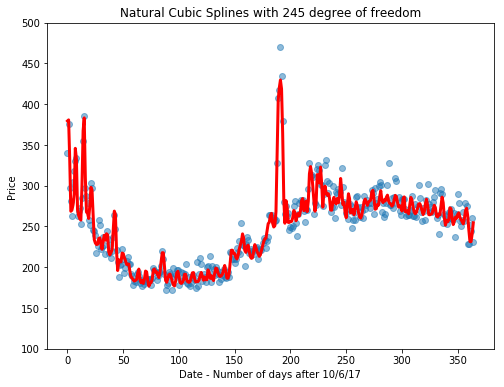

In [65]:
plt.figure(figsize = (8,6))
plt.ylim(100,500)
plt.scatter(new_test['date'], new_test['price'],alpha=0.5, label = 'test data')
plt.plot(new_test['date'], predictions_ns, c='r', linewidth=3, label = 'prediction')
plt.title('Natural Cubic Splines with {} degree of freedom'.format(max_df))
plt.xlabel("Date - Number of days after 10/6/17")
plt.ylabel("Price")

**We select the best number of degree of freedom by cross validation and find out the best d.f. is 245 and the $R^2$ on the test set is 0.9341. Based on the above two plots, we could find that more knots will lead to a better $R^2$ on the test set but it will also lead to overfitting if the number of knots is large. However, a better $R^2$ does not mean a better model performance since only using $R^2$ as the metric will also lead to overfitting when there are more than one predictors. Thus why we use cross validation to select the best d.f.**

**Smoothing Splines with the smoothness parameter chosen by cross-validation on the training set.**

In [68]:
r_price = robjects.FloatVector(new_train['price'])
r_smooth_spline = robjects.r['smooth.spline'] #extract R function
spline_cv = r_smooth_spline(r_date, r_price, cv=True)
lambda_cv = spline_cv.rx2("lambda")[0]
# best smoothness parameter chosen
lambda_cv

1.9048078041522317e-08

In [69]:
spline_test = r_smooth_spline(test_r[1], test_r[0], spar=lambda_cv)

r2_smo_train = r2_score(new_train['price'], spline_train.rx2("y"))
r2_smo_test = r2_score(new_test['price'], spline_test.rx2("y"))

print("R2 for ns on train R^2:{}".format(r2_smo_train))
print("on test:{} ".format(r2_smo_test))

R2 for ns on train R^2:0.9486846023488521
on test:0.9390543347512835 


Text(0, 0.5, 'Price')

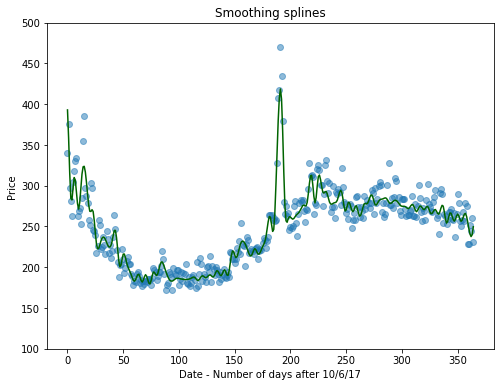

In [71]:
plt.figure(figsize = (8,6))
plt.ylim(100,500)
plt.scatter(new_test['date'], new_test['price'], alpha=0.5, label = 'test data')
plt.plot(spline_train.rx2("x"),spline_train.rx2("y"), color="darkgreen", label = 'prediction')
plt.title('Smoothing splines')
plt.xlabel("Date - Number of days after 10/6/17")
plt.ylabel("Price")

**Using cross-validation to choose the best regularization(smoothness) parameter. We won't need to choose the number of knots. It will less prone to overfitting and thus give the highest $R^2$ (0.9391) on the test set.**

### Part 1b: Adapting to weekends

Does the pattern of Airbnb pricing differ over the days of the week? Are the patterns on weekends different from those on weekdays? If so, we might benefit from using a different regression model for weekdays and weekends. Split the training and test data into two parts, one for weekdays and one for weekends, and fit a separate model for each training subset. Do the models yield a higher $R^2$ on the corresponding test subsets compared to the model fitted previously?

In [25]:
train_d = df_train.loc[df_train['weekday'].isin([5,6])]
train_e = df_train.loc[~df_train['weekday'].isin([5,6])]
test_d = df_test.loc[df_test['weekday'].isin([5,6])]
test_e = df_test.loc[~df_test['weekday'].isin([5,6])]

In [26]:
new_train_d = pd.DataFrame({'price' : (train_d.groupby('date_num')['price'].mean()).values,
                         'date': (train_d.groupby('date_num')['price'].mean()).index})
new_train_e = pd.DataFrame({'price' : (train_e.groupby('date_num')['price'].mean()).values,
                         'date': (train_e.groupby('date_num')['price'].mean()).index})
new_test_d = pd.DataFrame({'price' : (test_d.groupby('date_num')['price'].mean()).values,
                         'date': (test_d.groupby('date_num')['price'].mean()).index})
new_test_e = pd.DataFrame({'price' : (test_e.groupby('date_num')['price'].mean()).values,
                         'date': (test_e.groupby('date_num')['price'].mean()).index})

In [27]:
r_price_d = robjects.FloatVector(new_train_d['price'])
r_price_e = robjects.FloatVector(new_train_e['price'])
r_date_d = robjects.FloatVector(new_train_d['date'])
r_date_e = robjects.FloatVector(new_train_e['date'])
df_r_d = robjects.DataFrame({"price":r_price_d, "date":r_date_d})
df_r_e = robjects.DataFrame({"price":r_price_e, "date":r_date_e})

In [28]:
poly5_formula_d = robjects.Formula("price~poly(date,25)")
poly5_formula_d.environment["price"] = r_price_d 
poly5_formula_d.environment["date"] = r_date_d
lm_poly5_d = r_lm(formula=poly5_formula_d, data=df_r_d)

poly5_formula_e = robjects.Formula("price~poly(date,25)")
poly5_formula_e.environment["price"] = r_price_e
poly5_formula_e.environment["date"] = r_date_e
lm_poly5_e = r_lm(formula=poly5_formula_e, data=df_r_e)

In [29]:
predict_df_d = robjects.DataFrame({"date": robjects.FloatVector(new_test_d['date'])})
predictions_d = r_predict(lm_poly5_d, predict_df_d)
predict_df_e = robjects.DataFrame({"date": robjects.FloatVector(new_test_e['date'])})
predictions_e = r_predict(lm_poly5_e, predict_df_e)

r2_test_d = r2_score(new_test_d['price'], predictions_d)
r2_test_e = r2_score(new_test_e['price'], predictions_e)

In [30]:
print(r2_test_d,r2_test_e)

0.7204551802438194 0.7766820409183389


**Yes, Airbnb pricing are higher on weekends than weekdays. When we split data into weekends and weekdays and make predictions seperately, (we choose polynomial regression model with degree 25), the $R^2$ on the test set of the weekdays will be lower while the that of weekend will be higher compared to the $R^2$ in part 1a. **

**We also tried some other different models, based on the other models, we would think when we split the data into weekdays and weekends, we mostly get better predictions. The pricing of weekend and weekdays might follow different distribution. However, in terms of polynomial degree 25 model, that the predictions on the weekdays are slightly worse might due to the arbitray selection when testing different polynomial degrees.**

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 3 most expensive dates. Given what you know about Boston, how might you explain why these 3 days happen to be so expensive?

In [32]:
new_train_sort = new_train.sort_values('price', ascending=False)
new_train_sort.head()

,price,date
190,432.680761,190
192,425.289528,192
191,417.170404,191
1,409.298701,1
189,393.609047,189


In [33]:
df_train.loc[df_train['date_num'].isin([190,192,191])]['date'].unique()

array([datetime.date(2018, 4, 16), datetime.date(2018, 4, 14),
       datetime.date(2018, 4, 15)], dtype=object)

The 2018 Boston Marathon was held in April 16, 2018 (4/16/18).

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [34]:
list_train = pd.read_csv('listings_train.csv')
list_test = pd.read_csv('listings_test.csv')

In [35]:
list_train.head()

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


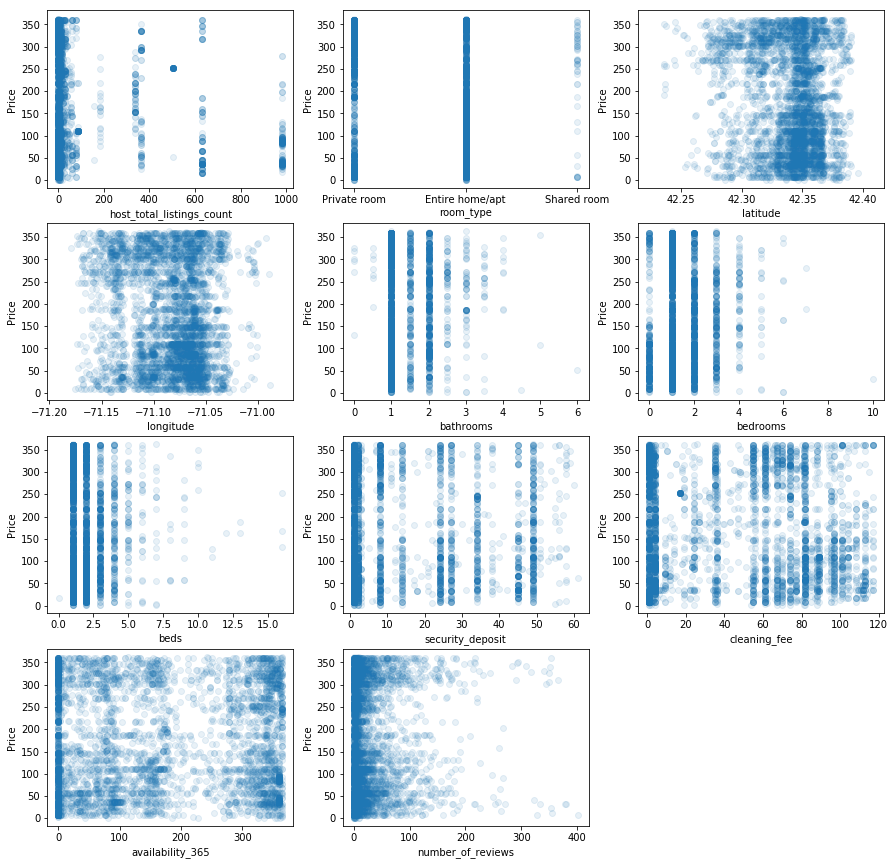

In [36]:
plt.figure(figsize=(15,15))
ind = 1
for i in list(list_train.drop('price',axis=1)):
    plt.subplot(4,3,ind)
    plt.scatter(list_train[i], list_train['price'],alpha=0.1)
    plt.ylabel('Price')
    plt.xlabel(i)
    ind = ind + 1

In [37]:
# import seaborn as sns
# sns.pairplot(data=list_train,
#                   x_vars=list(list_train.drop('price',axis=1)),
#                   y_vars=['price'])

**Yes, most of the covariates have non-linear relationship with response variable.**

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial baseis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [38]:
list_train_dummy = pd.get_dummies(list_train,prefix=['room_type'])
list_test_dummy = pd.get_dummies(list_test,prefix=['room_type'])

In [39]:
list_train_dummy.head()

,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,1,42.347956,-71.155196,1.0,1,1,52,1,65,365,26,0,1,0
1,85,42.349299,-71.083470,1.0,0,1,110,1,104,107,38,1,0,0
2,6,42.341902,-71.073792,1.0,1,1,67,45,56,322,9,1,0,0
3,1,42.319235,-71.105016,2.0,2,2,103,8,113,341,49,1,0,0
4,1,42.346452,-71.134896,1.0,0,1,8,24,82,41,13,1,0,0


In [40]:
list_train_dummy = list_train_dummy.rename(columns={'room_type_Entire home/apt': 'entire', 
                                                    'room_type_Private room': 'private',
                                                    'room_type_Shared room': 'shared'})
list_test_dummy = list_test_dummy.rename(columns={'room_type_Entire home/apt': 'entire', 
                                                    'room_type_Private room': 'private',
                                                    'room_type_Shared room': 'shared'})

In [41]:
x_var = list(list_train.drop(['price','room_type'],axis=1))
x_var_dummy = list(list_train_dummy.drop('price',axis=1))

**Linear regression**

In [42]:
simple_y_train = list_train['price']
simple_x_train = list_train_dummy.drop('price',axis=1)
simple_x_test = list_test_dummy.drop('price',axis=1)

model1 = sm.OLS(simple_y_train, simple_x_train)
simple_lm = model1.fit()

In [43]:
simple_pre = simple_lm.predict(simple_x_test)
r2_simple = r2_score(list_test_dummy['price'], simple_pre)
r2_simple

0.1847912723112639

**Regression with polynomial basis functions of degree 3**

In [44]:
def poly_feature(df, columns, n):
    poly_df = df.copy()
    for j in range(2,n+1):
        for i in columns:
             poly_df[i+'^'+'{:d}'.format(j)] = poly_df[i]**j
    return poly_df

In [45]:
list_train_poly = poly_feature(list_train_dummy, columns = x_var, n = 3)
list_test_poly = poly_feature(list_test_dummy, columns = x_var, n = 3)
#print(list(list_train_poly))
display(list_train_poly.head())

,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,...,host_total_listings_count^3,latitude^3,longitude^3,bathrooms^3,bedrooms^3,beds^3,security_deposit^3,cleaning_fee^3,availability_365^3,number_of_reviews^3
0,1,42.347956,-71.155196,1.0,1,1,52,1,65,365,...,1,75944.678316,-360263.164628,1.0,1,1,1,274625,48627125,17576
1,85,42.349299,-71.083470,1.0,0,1,110,1,104,107,...,614125,75951.906825,-359174.803290,1.0,0,1,1,1124864,1225043,54872
2,6,42.341902,-71.073792,1.0,1,1,67,45,56,322,...,216,75912.114951,-359028.111947,1.0,1,1,91125,175616,33386248,729
3,1,42.319235,-71.105016,2.0,2,2,103,8,113,341,...,1,75790.264015,-359501.506194,8.0,8,8,512,1442897,39651821,117649
4,1,42.346452,-71.134896,1.0,0,1,8,24,82,41,...,1,75936.591767,-359954.906714,1.0,0,1,13824,551368,68921,2197


In [46]:
y_train = list_train_poly['price']
x_train = list_train_poly.drop('price',axis=1)
x_test = list_test_poly.drop('price',axis=1)

poly_lm = sm.OLS(y_train, x_train).fit()

In [47]:
poly_pre = poly_lm.predict(x_test)
r2_poly = r2_score(list_test_poly['price'], poly_pre)

In [48]:
r2_poly

0.23784198561397107

**Based on the above, we could see that adding the polynomial terms will better capture the nonlinear patterns in the response variable (price). Thus, the $R^2$ on the test set of polynomial basis functions of degree 3 is higher than linear regression.**

### Part 2b: Generalized Additive Model (GAM)

*Helpful Hint:  Please refer to the lecture ipynb for the code template to perform GAM*

Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


In [49]:
x_train_dummy = pd.DataFrame(list_train_dummy.drop('price',axis=1))
y_train_dummy = list_train_dummy['price']

In [50]:
r_gam_lib = importr('gam')
r_gam = r_gam_lib.gam

#for i in list(list_train_dummy):
    #globals()["train_r_" + i] = robjects.FloatVector(list_train_dummy[i].values)
    #globals()["test_r_" + i] = robjects.FloatVector(list_test_dummy[i].values)

In [69]:
def generate_formula(df):
    formula = 'price ~ as.factor(entire) + as.factor(shared) + as.factor(private) +'
    for i in list(x_train_dummy)[:-5]:
        formula += 's({},df={}) +'.format(i,df)
    formula += 's({},df={})'.format(list(x_train_dummy)[-4],df)
    return formula
formula = generate_formula(df=3)
formula

'price ~ as.factor(entire) + as.factor(shared) + as.factor(private) +s(host_total_listings_count,df=3) +s(latitude,df=3) +s(longitude,df=3) +s(bathrooms,df=3) +s(bedrooms,df=3) +s(beds,df=3) +s(security_deposit,df=3) +s(cleaning_fee,df=3) +s(number_of_reviews,df=3)'

In [70]:
gam_formula = robjects.Formula(formula)

In [71]:
def make_gam_df(df):
    gam_df = pd.DataFrame(columns = list(df))
    gam_df = robjects.DataFrame({'host_total_listings_count': robjects.FloatVector(df['host_total_listings_count']), 
                                 'latitude': robjects.FloatVector(df['latitude']), 
                                   'longitude': robjects.FloatVector(df['longitude']),
                                   'price': robjects.FloatVector(df['price']),
                                   'bathrooms': robjects.FloatVector(df['bathrooms']),
                                   'bedrooms': robjects.FloatVector(df['bedrooms']),
                                   'beds': robjects.FloatVector(df['beds']),
                                   'security_deposit': robjects.FloatVector(df['security_deposit']),
                                   'cleaning_fee': robjects.FloatVector(df['cleaning_fee']),
                                   'number_of_reviews': robjects.FloatVector(df['number_of_reviews']),
                                   'entire': robjects.FloatVector(df['entire']),
                                   'private': robjects.FloatVector(df['private']),
                                   'shared': robjects.FloatVector(df['shared'])
                                  })
    return gam_df

In [72]:
# Cross validation for tuning parameter of GAM model
Score=[]
foldscore=[]
kf = KFold(n_splits = 5,shuffle = True)
for i in range(2,11): 
    for train_index, test_index in kf.split(list_train):
        train, test = list_train_dummy.iloc[train_index], list_train_dummy.iloc[test_index]
        gam_train = make_gam_df(train)
        gam_test = make_gam_df(test)
        formula = generate_formula(df=i)
        gam_formula = robjects.Formula(formula)
        gam_model = r_gam(gam_formula, data=gam_train)
        predictions = r_predict(gam_model, gam_test)
        score = r2_score(test['price'], predictions)
        Score.append(score)     
            
    foldscore.append(np.mean(Score))

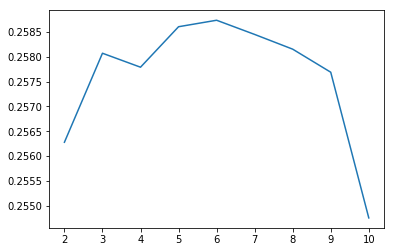

In [73]:
plt.figure(figsize = [6,4])
plt.plot(range(2,11), foldscore)

Based on the cross validation result, when the tuning parameter (df) equals to 6, $R^2$ is the highest.

In [77]:
# Fit GAM model with df=6
gam_train = make_gam_df(list_train_dummy)
gam_test = make_gam_df(list_test_dummy)
formula = generate_formula(6)
gam_formula = robjects.Formula(formula)
gam_model = r_gam(gam_formula, data=gam_train)
predictions = r_predict(gam_model, gam_test)
r2_test_gam = r2_score(list_test_dummy['price'], predictions)

In [78]:
r2_test_gam

0.24865887666568376

**Results**
Based on the above result, the GAM does give a better $R^2$ on the test set compared to the above two models. 

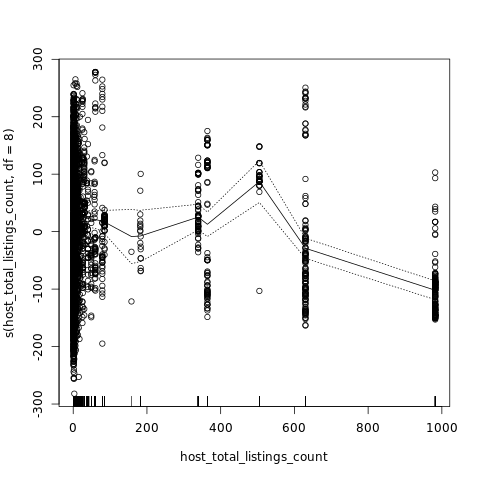

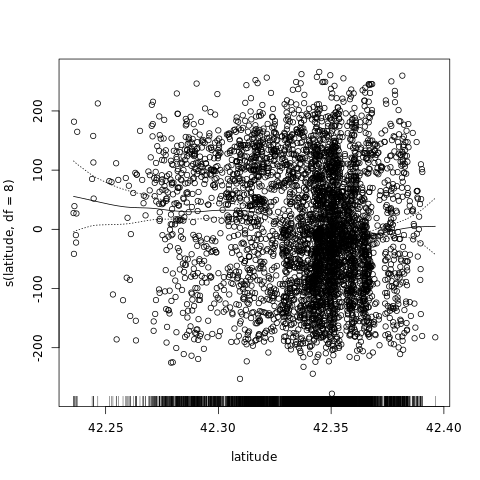

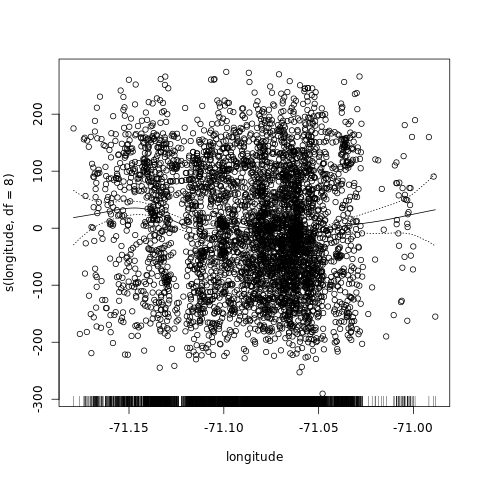

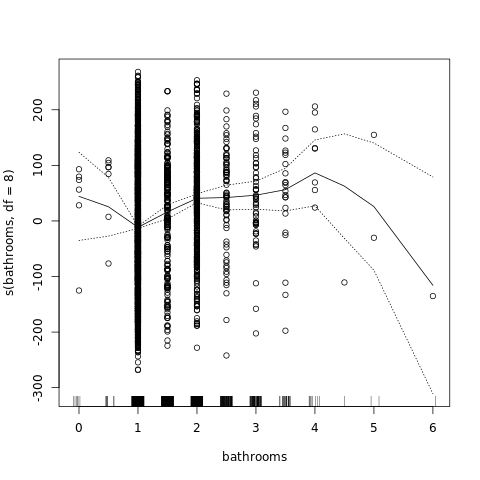

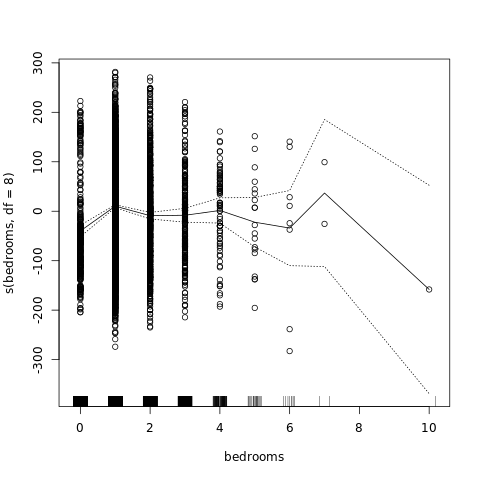

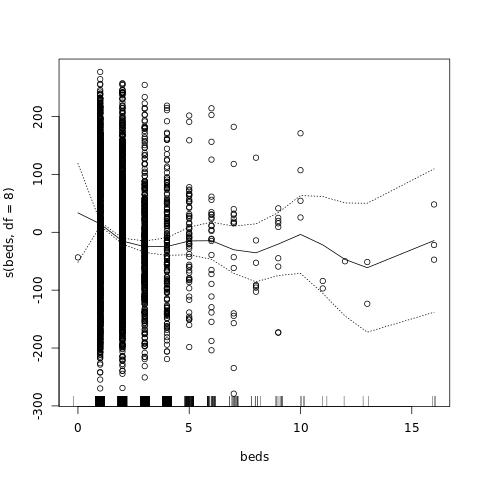

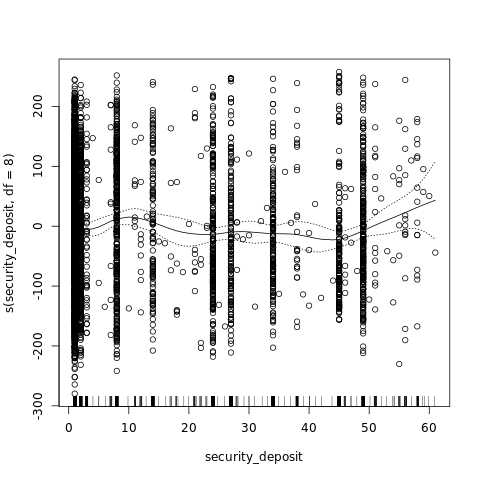

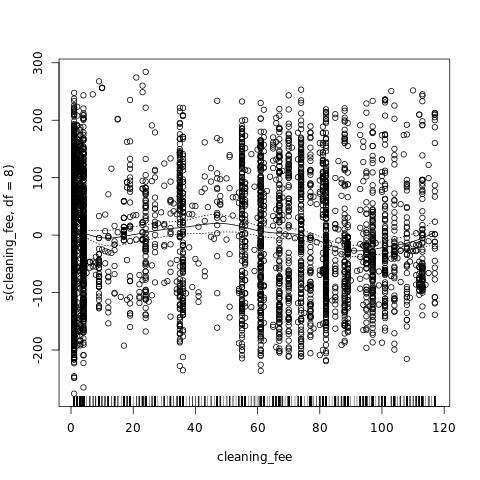

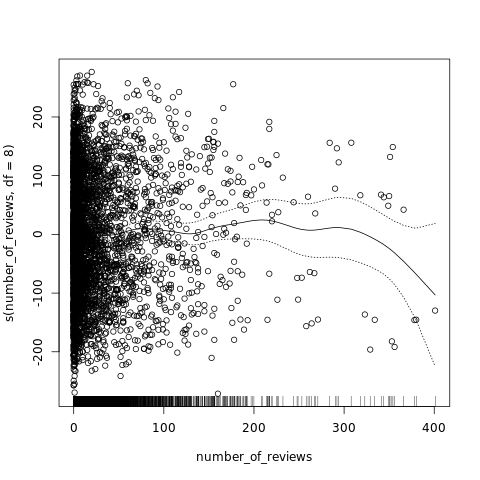

In [60]:
%load_ext rpy2.ipython

%R -i gam_model plot(gam_model, residuals=TRUE,se=TRUE, scale=100);

Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

- When fitting models above, all the predictors are treated equally, so that the features may only capture the relationships between response variable and some of the predictors.GAM can fit the relationship between each predictors and the response variable then adding all the functions together. This allows the different nature being treated differently and maximize the accountability of the models to the data variance. 

- GAM do not assume a priori any specific form of this relationship, and can be used to reveal and estimate non-linear effects of the covariate on the dependent variable. Polynomials are a very restrictive form of a curve - the GAM adapts the fitted curve to the data and is much more flexible than a polynomial.

What are some useful insights conveyed by these plots?

- the average price for entire home is cheaper than the price for shared and private room.

- most hosts have only several rooms, whilehosts that posting large quantity of rooms may give price lower than average.

- From the 3rd and 4th plots, we can see the price doesn't vary a lot within the location

- the more bathrooms/bedrooms, the higher price

- the bed counts, deposit counts, cleaning fee, and view counts doesn't have obvious effect on price.

### Part 2c: Putting it All Together

Based on your analysis for problems 1 and 2, what advice would you give a frugal visitor to Boston looking to save some money on an Airbnb rental?



**Advice:**

** - Visit Boston during November to March, pricing will be lowest during December to January.**

** - Visit Boston during the weekdays**

** - rent entire home or spots near to downtown, the price for entire home is economical and that the location won't be a important fator towards price. **

** - Try to avoid the dates for special events, especialy the sports event. Do not visit Boston during the week of Boston Marathon**

** - Book the room early, even during the peak months, there might still be relatively cheap rooms available.**

** - Houses with less bathrooms and bedrooms on average have slightly lower price.**

** - Reviews does not matter much.**